# Imports

In [52]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset, Audio
from datasets.utils.logging import disable_progress_bar
import torch
import jiwer
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

#set seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

disable_progress_bar()

# Dataset

## All Dataset

In [2]:
cv_ds = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test")

### Resampling to 16khz

In [3]:
cv_ds_resampled = cv_ds.cast_column("audio", Audio(sampling_rate=16_000))

In [4]:
cv_ds_resampled[0]['audio']

{'path': '/Users/fcisternas/.cache/huggingface/datasets/downloads/extracted/cfa5048bbba7d7c22ca918e45480425dde8f95c9f9dba6658173f7795baec0e8/en_test_0/common_voice_en_27710027.mp3',
 'array': array([-1.39698386e-09, -1.39698386e-09, -1.39698386e-09, ...,
         7.56168447e-07,  8.44313035e-07,  1.62357173e-06]),
 'sampling_rate': 16000}

## Single Example

In [54]:
example = cv_ds_resampled[7]

In [43]:
example

{'client_id': '001519f234e04528a2b36158c205dbe61c8da45ab0242f8800d6c4c2e9ac6ca76c9e5af86a313ab309f426c44204dfa7d2bb14b37ed565af9c1c6c86943675f9',
 'path': '/Users/fcisternas/.cache/huggingface/datasets/downloads/extracted/cfa5048bbba7d7c22ca918e45480425dde8f95c9f9dba6658173f7795baec0e8/en_test_0/common_voice_en_27340672.mp3',
 'audio': {'path': '/Users/fcisternas/.cache/huggingface/datasets/downloads/extracted/cfa5048bbba7d7c22ca918e45480425dde8f95c9f9dba6658173f7795baec0e8/en_test_0/common_voice_en_27340672.mp3',
  'array': array([ 2.91038305e-11, -1.16415322e-10,  4.36557457e-11, ...,
         -3.91066351e-05, -4.22631601e-05, -5.29778117e-05]),
  'sampling_rate': 16000},
 'sentence': 'It is a busy market town that serves a large surrounding area.',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'en',
 'segment': ''}

# Wav2Vec2

## single Inference

In [38]:
# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.masked_spec_embed']
You sho

In [44]:
# tokenize
input_values = processor(example["audio"]["array"], sampling_rate= example["audio"]['sampling_rate'], return_tensors="pt", padding="longest").input_values  # Batch size 1

In [32]:
# retrieve logits
logits = model(input_values).logits
logits

tensor([[[ 15.2774, -29.4570, -29.1264,  ...,  -7.3897,  -7.6856,  -7.7527],
         [ 15.5120, -29.7179, -29.3629,  ...,  -7.6415,  -8.1293,  -7.9722],
         [ 15.3720, -29.6300, -29.2653,  ...,  -7.5799,  -8.1160,  -7.9424],
         ...,
         [ 15.4376, -29.7290, -29.3766,  ...,  -7.4465,  -8.2410,  -7.6630],
         [ 15.1762, -29.6147, -29.2642,  ...,  -7.5191,  -8.2697,  -7.7248],
         [ 15.2286, -29.5750, -29.2348,  ...,  -7.6091,  -8.2701,  -7.8104]]],
       grad_fn=<ViewBackward0>)

In [33]:
# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
predicted_ids

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0, 29,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  4,  0, 26,
          0,  0,  5,  0,  0,  5,  0, 23,  0,  0, 12,  0,  0,  0,  7,  0,  9,  0,
          0,  4,  4, 14,  0,  0, 10,  0, 12,  0,  0,  0,  0,  7, 23,  0,  0,  0,
         23,  0, 13,  0,  0,  0,  0,  8,  0, 25,  0,  0,  5, 14,  0,  4,  4,  0,
          0,  8, 20,  0,  4,  4,  4,  4,  0,  0,  6,  0,  0,  0,  0,  0,  8,  0,
          0,  0,  9,  5,  0,  0, 12, 12,  4,  4,  0,  0,  0,  0,  7,  9,  0, 14,
          0,  4,  4,  4,  0, 24,  0,  0,  0, 16,  0,  0, 12, 12,  0,  6,  0,  0,
          0,  5, 13, 13,  0,  4,  4,  0,  0,  7, 15,  0,  0,  0,  0, 12,  0,  0,
          8,  0,  4,  4,  0, 11,  0,  0,  7,  0,  0, 14,  4,  4,  4, 11,  0,  0,
          5,  0,  0,  0, 12,  0,  0,  5, 13, 13,  0,  0, 25,  0,  0,  0,  0,  7,
          0,  0,  0,  0,  6,

In [34]:
transcription = processor.batch_decode(predicted_ids)
transcription

['JO KEEPSAN DISAPPROVED OF TONES AND BUSTER ALSO HAD HESERVATIONS ABOUT THE MEDIUM']

In [35]:
example['sentence']

'Joe Keaton disapproved of films, and Buster also had reservations about the medium.'

## Eval

In [7]:
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You sho

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


In [8]:
def map_to_pred(batch):
    input_values = processor(batch["audio"]["array"], sampling_rate=batch["audio"]["sampling_rate"], return_tensors="pt", padding="longest").input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["transcription"] = transcription
    return batch

In [10]:
result = cv_ds_resampled.map(map_to_pred)

Parameter 'function'=<function map_to_pred at 0x2a5de45e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/16354 [00:00<?, ? examples/s]

In [27]:
preds_list = [result['transcription'][i][0] for i in range(len(result['transcription']))]

In [31]:
print("WER:", jiwer.wer(result["sentence"],preds_list))

WER: 1.0358907978347847


# Whisper

## Single Inference

In [50]:
# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
model.config.forced_decoder_ids = None

In [88]:
input_features = processor(example["audio"]["array"], sampling_rate=example["audio"]["sampling_rate"], return_tensors="pt").input_features 

In [89]:
input_features

tensor([[[-0.7811, -0.7811, -0.7811,  ..., -0.7811, -0.7811, -0.7811],
         [-0.7811, -0.7811, -0.7811,  ..., -0.7811, -0.7811, -0.7811],
         [-0.7811, -0.7811, -0.7811,  ..., -0.7811, -0.7811, -0.7811],
         ...,
         [-0.7811, -0.7811, -0.7811,  ..., -0.7811, -0.7811, -0.7811],
         [-0.7811, -0.7811, -0.7811,  ..., -0.7811, -0.7811, -0.7811],
         [-0.7811, -0.7811, -0.7811,  ..., -0.7811, -0.7811, -0.7811]]])

In [38]:
# generate token ids
predicted_ids = model.generate(input_features)
predicted_ids

tensor([[50258, 50259, 50359, 50363,  6807,  3189, 25781,  4518,   340,   937,
           295,  7796,   293,   363,  8393,   611,   632, 40222,   466,   264,
          6399,    13, 50257]])

In [40]:
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=False)
transcription

['<|startoftranscript|><|en|><|transcribe|><|notimestamps|> Joe Keaton disapproved of films and Buster also had reservations about the medium.<|endoftext|>']

In [41]:
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
transcription

[' Joe Keaton disapproved of films and Buster also had reservations about the medium.']

In [39]:
example['sentence']

'Joe Keaton disapproved of films, and Buster also had reservations about the medium.'

## Eval

In [4]:
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

In [102]:
def map_to_pred(batch):
    audio = batch["audio"]
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features
    batch["reference"] = processor.tokenizer._normalize(batch['sentence'])

    with torch.no_grad():
        predicted_ids = model.generate(input_features)[0]
    transcription = processor.decode(predicted_ids)
    batch["transcription"] = processor.tokenizer._normalize(transcription)
    return batch

In [6]:
result = cv_ds_resampled.map(map_to_pred)

Map:   0%|          | 0/16354 [00:00<?, ? examples/s]

In [7]:
result['transcription']

['joel keaton disapproved of films and buster also had reservations about the medium',
 'she would be alright',
 '6',
 'all as well that ends well',
 'it is a busy market town that serves a large surrounded area',
 'the team had all of the champion kero leda madden and this quad for this season',
 'do you mean it',
 'the new patch is less invasive than the whole one still causes regression',
 'how is most of you are going to handle and be with this thank you and q',
 'we shall see you in the next one',
 'no one near the remote machine you could ring',
 'soss for the goose is sass for the gonder',
 'gramps is thought of writing songs when she was 4 years old',
 'even kerm mike schula was the former h good at alabama',
 'the response was that the ball did not appoint individual officers',
 'the long lived bridge till stands today',
 'there was nothing to work between that except himself',
 'the meat processing and construction industries would be allowed to operate with radio spersonal',

In [8]:
print("WER:",100 * jiwer.wer(result["reference"], result["transcription"]))

WER: 34.95643226905887


# Saliency 

## Load Dataset

In [12]:
cv_ds = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test") #load dataset

sr = 16_000

cv_ds_resampled = cv_ds.cast_column("audio", Audio(sampling_rate=sr)) #resample to 16kHz

In [13]:
max_examples = 100

cv_ds_saliency = cv_ds_resampled.select(range(0, max_examples))
cv_ds_saliency

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
    num_rows: 100
})

## Saliency with Whisper

In [75]:
# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
model.config.forced_decoder_ids = None

In [76]:
def apply_processor(batch, dim_selected, saliency):
    features = processor(batch["audio"]["array"], sampling_rate=batch["audio"]["sampling_rate"], return_tensors="pt").input_features
    if saliency:
        # Establece a cero la dimensión seleccionada
        features[:, dim_selected] = 0
    batch["input_features"] = features
    return batch

In [77]:
def map_to_pred_with_saliency(batch):
    input_features = torch.asarray(batch["input_features"])
    batch["reference"] = processor.tokenizer._normalize(batch['sentence'])

    with torch.no_grad():
        predicted_ids = model.generate(input_features)[0]
    transcription = processor.decode(predicted_ids)
    batch["transcription"] = processor.tokenizer._normalize(transcription)
    return batch

In [108]:
# Define la dimensión que quieres anular
dim_to_zero_out = 4  # dimension a eliminar [0,79]

# Llama a .map() con el nuevo parámetro usando fn_kwargs
cv_ds_saliency_prep = cv_ds_saliency.map(apply_processor, fn_kwargs={'dim_selected': dim_to_zero_out, 'saliency': True})

cv_ds_no_saliency_prep = cv_ds_saliency.map(apply_processor, fn_kwargs={'dim_selected': dim_to_zero_out, 'saliency': False})


In [109]:
print('Original Array:',np.asarray(cv_ds_no_saliency_prep[0]['input_features'][0])[dim_to_zero_out])

print('Saliency Array:',np.asarray(cv_ds_saliency_prep[0]['input_features'][0])[dim_to_zero_out])

Original Array: [-0.5807786 -0.5807786 -0.5807786 ... -0.5807786 -0.5807786 -0.5807786]
Saliency Array: [0. 0. 0. ... 0. 0. 0.]


### viz salency

In [110]:
mel_whisper_single_example = np.asarray(cv_ds_saliency_prep[0]['input_features'][0])

In [111]:
cv_ds_saliency_prep[0]['sentence']

'Joe Keaton disapproved of films, and Buster also had reservations about the medium.'

In [112]:
mel_whisper_single_example.shape

(80, 3000)

In [113]:
# Calcular las frecuencias de las bandas de Mel
mel_frequencies = librosa.mel_frequencies(n_mels=80, fmax=8000)

# La frecuencia correspondiente a la séptima banda de Mel en Hz
frequency_of_seventh_mel_band = mel_frequencies[dim_to_zero_out]

In [114]:
frequency_of_seventh_mel_band

152.72790032717288

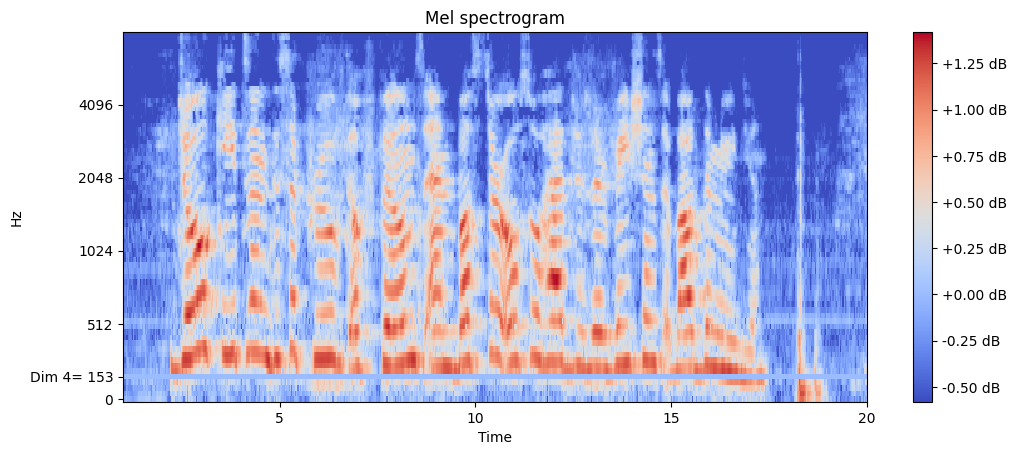

In [115]:
plt.figure().set_figwidth(12)
librosa.display.specshow(mel_whisper_single_example, x_axis="time", y_axis="mel", sr=sr, fmax=8000)
plt.xlim([1, 20])
# Obtener los ticks actuales
current_yticks = plt.gca().get_yticks()
y_ticks_labels = [str(int(element)) for element in current_yticks]
# Combinar los ticks actuales con el nuevo tick
all_yticks = np.append(current_yticks, frequency_of_seventh_mel_band)
all_ytick_labels = y_ticks_labels + [f"Dim {dim_to_zero_out}= {frequency_of_seventh_mel_band:.0f}"]

# Establecer los ticks y etiquetas actualizados
plt.yticks(all_yticks, all_ytick_labels)
#plt.yticks([frequency_of_seventh_mel_band], ["Dimension 7"])
#plt.colorbar()
plt.title("Mel spectrogram")
plt.colorbar(format="%+2.2f dB")
plt.show()

## prediction on the new inputs

In [147]:
preds_with_saliency = cv_ds_saliency_prep.map(map_to_pred_with_saliency) #predictions with dimension dropped
preds_no_saliency = cv_ds_no_saliency_prep.map(map_to_pred_with_saliency) #predictions without dimension dropped

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [153]:
print("WER Saliency:",100 * jiwer.wer(preds_with_saliency["reference"], preds_with_saliency["transcription"])) #WER with saliency

print("WER No Saliency:",100 * jiwer.wer(preds_no_saliency["reference"], preds_no_saliency["transcription"])) #WER without saliency

print("WER between:",100 * jiwer.wer(preds_with_saliency["reference"], preds_no_saliency["reference"])) #WER between original reference and saliency reference

WER Saliency: 34.73360655737705
WER No Saliency: 65.3688524590164
WER between: 0.0


## Compare Preds

In [154]:
preds_with_saliency["transcription"]

['joel keaton disapproved of films and buster also had reservations about the medium',
 'she would be alright',
 '6',
 'all as well that ends well',
 'it is a busy market town that serves a large surrounded area',
 'the team had all of the champion kero leda madham in this quad 4th season',
 'долю мигит',
 'the new patch is less invasive than the whole one still causes regression',
 'how is most of you are going to handle mb with this thank you and q',
 '무신스의 날은 너무 없지',
 'no one near the remote machine you could ring',
 'soss for the goose is soss for the gonder',
 'gramps is thought of writing songs when she was 4 years old',
 'even kerm mike schula was the former h good at alabama',
 'the response was that the ball did not appoint individual officers',
 'the long lived bridge tears stands today',
 'there was nothing to work with him back except himself',
 'the meat processing and construction industries would be allowed to operate with radio spersonal',
 'coles branch i

In [155]:
preds_no_saliency["transcription"]

['joel keaton disapproved of films and buster also had reservations about the medium',
 'she would be alright',
 '6',
 'all as well that ends well',
 'it is a busy market town that serves a large surrounded area',
 'the team had all of the champion kero leda madden and this quad for this season',
 'долю миг дит',
 'the new patch is less invasive than the whole one still causes regression',
 'how is most of you are going to handle and be with this thank you and q',
 '무신스에 대한 뜻을 up지',
 'no one near the remote machine you could ring',
 'soss for the goose is sass for the gonder',
 'gramps is thought of writing songs when she was 4 years old',
 'even kerm mike schula was the former h good at alabama',
 'the response was that the ball did not appoint individual officers',
 'the long lived bridge till stands today',
 'there was nothing to work between that except himself',
 'the meat processing and construction industries would be allowed to operate with radio spersonal',
 'cole

# Automatic Importance

In [53]:
sr = 16_000

cv_ds = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test") #load dataset

cv_ds_resampled = cv_ds.cast_column("audio", Audio(sampling_rate=sr)) #resample to 16kHz

cv_ds_resampled = cv_ds_resampled.select_columns(["audio", "sentence"]) #Keep only audio and sentence columns

In [57]:
#max_examples = 1
id_example = 100

cv_ds_saliency = cv_ds_resampled.select(range(0, id_example)) #select examples

#cv_ds_saliency = cv_ds_resampled[id_example] #select examples

print(cv_ds_saliency['sentence'])

['Joe Keaton disapproved of films, and Buster also had reservations about the medium.', "She'll be all right.", 'six', "All's well that ends well.", 'It is a busy market town that serves a large surrounding area.', 'The team had Olympic Champion Carolina Marin in their squad for the season.', 'Do you mean it?', 'The new patch is less invasive than the old one, but still causes regressions.', 'How is Mozilla going to handle ambiguities like queue and cue?', "I guess you must think I'm kinda batty.", 'No one near the remote machine you could ring?', 'Sauce for the goose is sauce for the gander.', 'Groves started writing songs when she was four years old.', 'His uncle Mike Shula was the former head coach at Alabama.', 'The response was that the Board did not appoint individual officers.', 'The long-lived bridge still stands today.', 'There was nothing to hold him back except himself.', 'The meat processing and construction industries would be allowed to operate with reduced personnel.', '

In [54]:
# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
model.config.forced_decoder_ids = None

In [58]:
cv_ds_saliency

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 100
})

In [59]:
def apply_processor(batch):
    batch["input_features"] = processor(batch["audio"]["array"], sampling_rate=batch["audio"]["sampling_rate"], return_tensors="pt").input_features
    return batch

In [60]:
def apply_saliency(batch, dim_selected):
    features = torch.asarray(batch["input_features"])
    for dim in dim_selected:
        features[:, dim] = 0
    batch["input_features"] = features
    return batch

In [61]:
def get_reference(batch):
    batch["reference"] = processor.tokenizer._normalize(batch['sentence'])
    return batch

In [62]:
def map_to_pred(batch):
    input_features = torch.asarray(batch["input_features"])
    with torch.no_grad():
        predicted_ids = model.generate(input_features)[0]
    transcription = processor.decode(predicted_ids)
    batch["transcription"] = processor.tokenizer._normalize(transcription)
    return batch

In [63]:
def calculate_metrics(reference, hypothesis):
    metrics = {}
    output_words = jiwer.process_words(reference, hypothesis)
    outpur_chars = jiwer.process_characters(reference, hypothesis)

    metrics["WER"] = output_words.wer
    metrics['MER'] = output_words.mer
    metrics['WIL'] = output_words.wil
    metrics['WIP'] = output_words.wip
    metrics['CER'] = outpur_chars.cer

    return metrics

In [64]:
def generate_metrics(dataset, max_dims=80):
    metrics = {}
    print("Generating metrics for dataset")
    reference = dataset.map(get_reference) #get original reference
    print("Original reference generated")
    preds_no_saliency = dataset.map(map_to_pred) #get predictions with no saliency
    print("Predictions without saliency generated")
    metrics_baseline = calculate_metrics(reference["reference"], preds_no_saliency["transcription"]) #compute metrics

    #use tqdm to show progress bar
    for dim in tqdm(range(max_dims)):
    #for dim in range(max_dims):
        ds_saliency = dataset.map(apply_saliency, fn_kwargs={'dim_selected': [dim]}) #drop dimension
        preds_saliency = ds_saliency.map(map_to_pred) #get predictions with saliency
        metrics_saliency = calculate_metrics(reference["reference"], preds_saliency["transcription"]) #compute metrics
        metrics[dim] = metrics_saliency

    return metrics, metrics_baseline

In [65]:
def calc_importance(metricas_baseline, metricas_objetivo):
    # Calcular la diferencia relativa
    diferencias_relativas = {}
    for key, objetivo in metricas_objetivo.items():
        diferencias_relativas[key] = {}
        total = 0
        for metrica, valor in objetivo.items():
            # Tratar 'WIP' de manera diferente
            if metrica == 'WIP':
                # Para 'WIP', un valor más alto es mejor
                imp = (metricas_baseline[metrica] - valor) / (metricas_baseline[metrica] + 1e-8)
                
            else:
                # Para otras métricas, un valor más bajo es mejor
                imp = -1*(metricas_baseline[metrica] - valor) / (metricas_baseline[metrica] + 1e-8)

            diferencias_relativas[key][metrica] = imp
            total += imp
        diferencias_relativas[key]['TOTAL'] = total

    return diferencias_relativas


In [66]:
def custom_column_scale(column):
    # Crear dos objetos MinMaxScaler
    scaler_positive = MinMaxScaler(feature_range=(0, 1))
    scaler_negative = MinMaxScaler(feature_range=(-1, 0))

    # Datos escalados (inicialmente una copia de la columna)
    scaled_column = np.zeros_like(column, dtype=float)

    # Escalar los valores positivos
    positive_mask = column > 0
    if positive_mask.any():
        scaler_positive.fit(column[positive_mask].values.reshape(-1, 1))
        scaled_column[positive_mask] = scaler_positive.transform(column[positive_mask].values.reshape(-1, 1)).flatten()

    # Escalar los valores negativos
    negative_mask = column < 0
    if negative_mask.any():
        scaler_negative.fit(column[negative_mask].values.reshape(-1, 1))
        scaled_column[negative_mask] = scaler_negative.transform(column[negative_mask].values.reshape(-1, 1)).flatten()

    # Los valores cero se mantienen como cero
    return scaled_column

def custom_scale(data):
    # Aplicar la función de escalado a cada columna
    scaled_data = pd.DataFrame({col: custom_column_scale(data[col]) for col in data.columns})

    return scaled_data

## Manual

In [67]:
#ds_no_dims = cv_ds_saliency.map(apply_processor).map(apply_saliency, fn_kwargs={'dim_selected': [1,4,8,58]})
ds_no_dims = cv_ds_saliency.map(apply_processor)

In [68]:
metrics_with_saliency, metrics_no_saliency = generate_metrics(ds_no_dims)
importance = calc_importance(metrics_no_saliency, metrics_with_saliency)

Generating metrics for dataset
Original reference generated
Predictions without saliency generated


100%|██████████| 80/80 [55:25<00:00, 41.57s/it] 


In [69]:
importance_df = pd.DataFrame.from_dict(importance, orient='index')
scaled_df = custom_scale(importance_df)
df_heatmap = scaled_df.T

In [70]:
importance_df.head(20)

,WER,MER,WIL,WIP,CER,TOTAL
0,-0.468652,-0.312702,-0.200849,-0.303002,-0.428758,-1.713963
1,-0.489028,-0.326831,-0.193197,-0.291459,-0.398257,-1.698771
2,-0.175549,-0.049844,0.024101,0.036359,-0.248366,-0.413299
3,2.956113,0.808929,0.547102,0.825363,4.064924,9.202430
4,7.601881,1.021599,0.639997,0.965506,9.800871,20.029855
5,1.967085,0.702487,0.497366,0.750331,2.193900,6.111169
6,0.379310,0.289708,0.258926,0.390618,0.559477,1.878039
7,0.075235,0.179881,0.197311,0.297666,0.010458,0.760551
8,-0.244514,-0.017142,0.083728,0.126312,-0.230065,-0.281681
9,0.437304,0.251398,0.205028,0.309307,0.439216,1.642252


In [71]:
importance_df.sum(axis=1).idxmin()

27

In [72]:
importance_df.sum(axis=1)[17]

-3.724516632077714

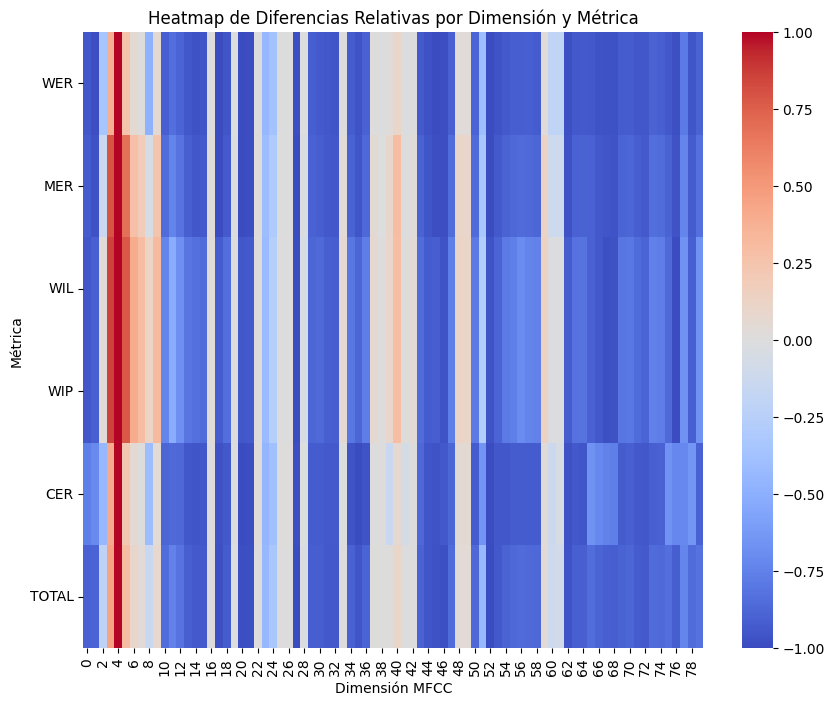

In [73]:
# Crear el heatmap usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap, annot=False, cmap='coolwarm')
plt.yticks(rotation=0)
plt.title('Heatmap de Diferencias Relativas por Dimensión y Métrica')
plt.xlabel('Dimensión MFCC')
plt.ylabel('Métrica')
plt.show()

## Automatic

In [26]:
def auto_neg_importance(dataset):
    l_dims = []
    ds_baseline = dataset.map(apply_processor)
    metrics_with_saliency, metrics_baseline = generate_metrics(ds_baseline)
    print('baseline:',metrics_baseline)
    print('saliency:',metrics_with_saliency)
    importance = calc_importance(metrics_baseline, metrics_with_saliency)
    print('importance:',importance)
    min_dim = min(importance, key = lambda k: importance[k]['TOTAL'])
    print('min_dim:',min_dim)
    min_importance = importance[min_dim]['TOTAL']
    print('min_importance:',min_importance)
    while min_importance < 0:
        print(f"Removing dimension {min_dim} with importance {min_importance}")
        print(f"WER: {metrics_baseline['WER']} -> {metrics_with_saliency[min_dim]['WER']}, improvement: {importance[min_dim]['WER']}")
        print(f"MER: {metrics_baseline['MER']} -> {metrics_with_saliency[min_dim]['MER']}, improvement: {importance[min_dim]['MER']}")
        print(f"WIL: {metrics_baseline['WIL']} -> {metrics_with_saliency[min_dim]['WIL']}, improvement: {importance[min_dim]['WIL']}")
        print(f"WIP: {metrics_baseline['WIP']} -> {metrics_with_saliency[min_dim]['WIP']}, improvement: {importance[min_dim]['WIP']}")
        print(f"CER: {metrics_baseline['CER']} -> {metrics_with_saliency[min_dim]['CER']}, improvement: {importance[min_dim]['CER']}")
        #print(f"Baseline score: {baseline_score} -> {sum(metrics_with_saliency[min_dim].values())}, improvement: {sum(importance[min_dim].values())}")
        print("-------------------------------------------------------")
        l_dims.append(min_dim)
        ds_temp = ds_baseline.map(apply_saliency, fn_kwargs={'dim_selected': l_dims})
        metrics_with_saliency, metrics_baseline = generate_metrics(ds_temp)
        importance = calc_importance(metrics_baseline, metrics_with_saliency)
        min_dim = min(importance, key = lambda k: importance[k]['TOTAL'])
        min_importance = importance[min_dim]['TOTAL']
        
    
    return l_dims

In [27]:
dims_to_drop = auto_neg_importance(cv_ds_saliency)

Generating metrics for dataset
Original reference generated
Predictions without saliency generated


100%|██████████| 80/80 [01:12<00:00,  1.10it/s]

baseline: {'WER': 0.1111111111111111, 'MER': 0.1111111111111111, 'WIL': 0.2098765432098766, 'WIP': 0.7901234567901234, 'CER': 0.04081632653061224}
saliency: {0: {'WER': 0.1111111111111111, 'MER': 0.1111111111111111, 'WIL': 0.2098765432098766, 'WIP': 0.7901234567901234, 'CER': 0.04081632653061224}, 1: {'WER': 0.1111111111111111, 'MER': 0.1111111111111111, 'WIL': 0.2098765432098766, 'WIP': 0.7901234567901234, 'CER': 0.04081632653061224}, 2: {'WER': 0.1111111111111111, 'MER': 0.1111111111111111, 'WIL': 0.2098765432098766, 'WIP': 0.7901234567901234, 'CER': 0.04081632653061224}, 3: {'WER': 0.1111111111111111, 'MER': 0.1111111111111111, 'WIL': 0.2098765432098766, 'WIP': 0.7901234567901234, 'CER': 0.04081632653061224}, 4: {'WER': 0.8888888888888888, 'MER': 0.8888888888888888, 'WIL': 0.9722222222222222, 'WIP': 0.027777777777777776, 'CER': 0.6938775510204082}, 5: {'WER': 0.4444444444444444, 'MER': 0.4444444444444444, 'WIL': 0.6527777777777778, 'WIP': 0.3472222222222222, 'CER': 0.163265306122448

In [20]:
dims_to_drop

[3]

## other

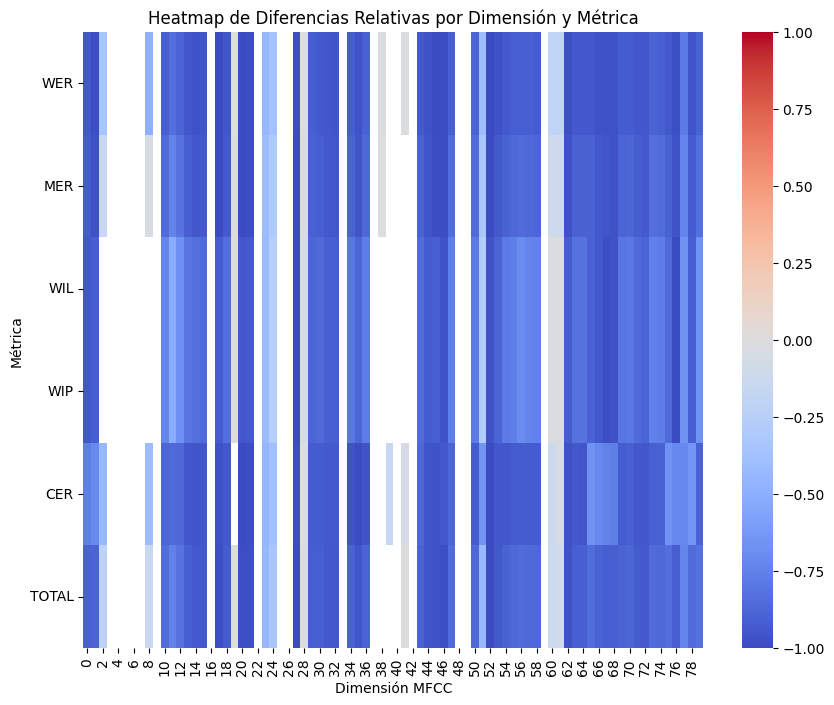

In [74]:
# Crear la máscara donde los valores menores que 0 serán True
mask = df_heatmap >= 0

# Crear el heatmap usando seaborn con la máscara aplicada
plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap, annot=False, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.yticks(rotation=0)
plt.title('Heatmap de Diferencias Relativas por Dimensión y Métrica')
plt.xlabel('Dimensión MFCC')
plt.ylabel('Métrica')
plt.show()


In [31]:
metric = 'CER'
min = 1

for i in range(len(metrics_with_saliency)):
    if min:
        if metrics_no_saliency[metric] > metrics_with_saliency[i][metric]:
            print(f'Dimension',i,metric,metrics_with_saliency[i][metric])
    else: 
        if metrics_no_saliency[metric] < metrics_with_saliency[i][metric]:
            print(f'Dimension',i,metric,metrics_with_saliency[i][metric])

Dimension 3 CER 0.0
Dimension 19 CER 0.0


In [17]:
importance_df.to_csv('importance.csv', index=False)

# Test rep_erasure.py

In [1]:
from models.representation_erasure import RepresentationErasure
from datasets import load_dataset

In [2]:
cv_ds = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test") #load dataset

In [3]:
rep_erasure = RepresentationErasure(cv_ds, max_examples=5)

Preprocessing dataset...
Generating original reference...
Generating original predictions...
Calculating baseline metrics...


Calculating Importance: 100%|██████████| 80/80 [00:00<00:00, 559240.53it/s]


Plotting importance...
Scaling importance...


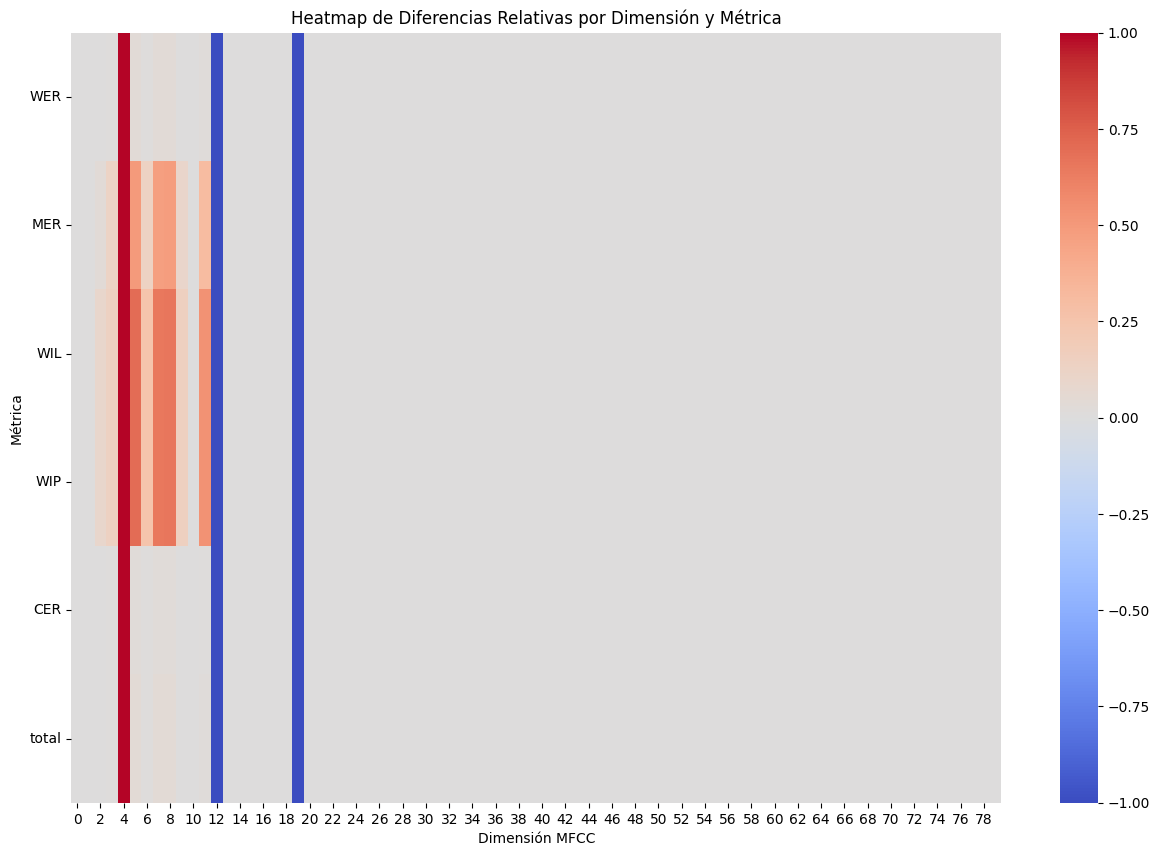

In [4]:
rep_erasure.explain()